In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans, KMeans
import setGPU
import numpy as np
import h5py

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import setGPU

import sys,os
#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('IDEC/')))
import idec_dense_AE as idec_mod
reload(idec_mod)
from idec_dense_AE import IDEC
import IDEC.utils as utils_idec
reload(utils_idec)
from scipy.sparse import csr_matrix

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from IDEC.utils import GraphDataset, cluster_acc
from torch_scatter import scatter_mean,scatter_max

from sklearn.manifold import TSNE

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


setGPU: Setting GPU to: 0


In [82]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/inputs/'
TRAIN_NAME = 'bkg_sig_0.0156_l1_filtered_padded.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'])

order_num_objets = [1,3,3,3,15,6]
order_names_objects = 'met,e,g,mu,j,b'.split(',')
num_feats = 4
feats = 'E,pt,eta,phi'.split(',')
#num_met_feats = 2

access_idx = [0] #num_met_feats]
for n_obj in order_num_objets:
    access_idx.append(access_idx[-1]+num_feats*n_obj)
print(access_idx)


[0, 4, 16, 28, 40, 100, 124]


In [83]:
def prepare_1d_datasets(file_dataset):
    proc_idx = 0
    dkl_idx = 1
    charge_idx = 2
    features_idx = [3,4,5,6]

    dataset_proc_truth = file_dataset[:,0,[proc_idx]]
    dataset_2d = file_dataset[:,:,features_idx]
    dataset_2d[:,:,0] = dataset_2d[:,:,0]/1e5 #E
    dataset_2d[:,:,1] = dataset_2d[:,:,1]/1e5 #pT
    #log of energy and pt as preprocessing
    dataset_2d[:,:,0] = np.log(dataset_2d[:,:,0]+1)
    dataset_2d[:,:,1] = np.log(dataset_2d[:,:,1]+1) 
    dataset_2d[:,0,1] = 0. #met pt is 0
    dataset_2d[:,0,2] = 0. #met eta is 0

    #dataset_met = dataset_2d[:,0,[0,-1]] #met is first , and only has E and phi
    #dataset_particles = dataset_2d[:,1:,:] #other particles follow , and have all features 
    #dataset_particles = dataset_particles.reshape((dataset_particles.shape[0],dataset_particles.shape[1]*dataset_particles.shape[2]))
    #dataset_1d = np.hstack([dataset_met,dataset_particles])
    
    dataset_1d = dataset_2d.reshape((dataset_2d.shape[0],dataset_2d.shape[1]*dataset_2d.shape[2]))

    return dataset_1d,dataset_proc_truth
    

    

In [84]:
file_dataset_1d,file_dataset_proc_truth = prepare_1d_datasets(file_dataset)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


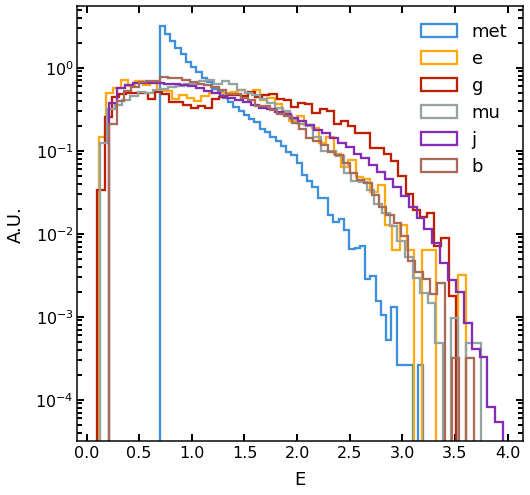

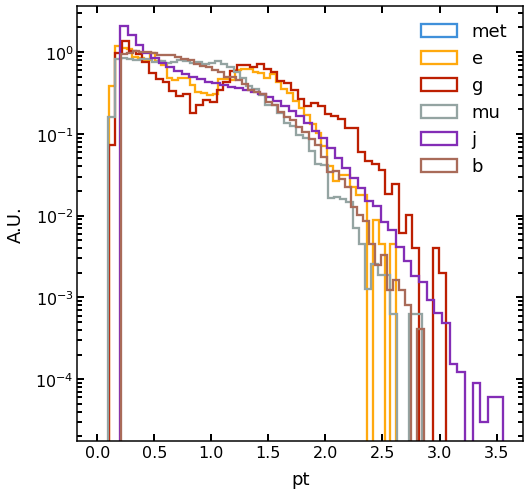

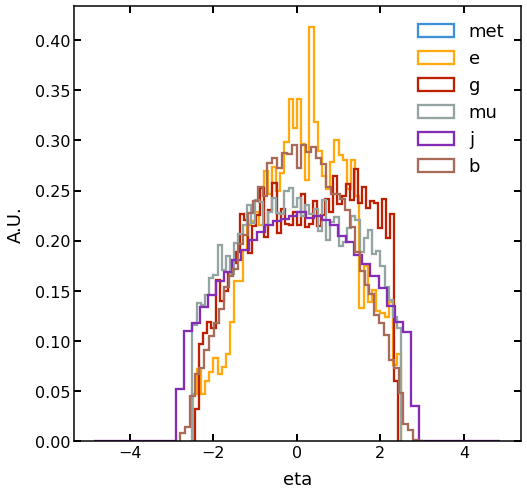

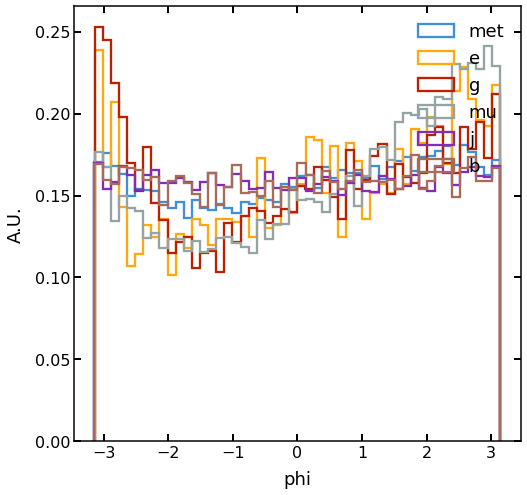

In [85]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_feat,feat in enumerate(feats):
    plt.figure(figsize=(8,8))
    for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
        data = file_dataset_1d[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask = data!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0,3,100)
        if feat=='eta':
            bins = np.linspace(-4,4,100)
       # elif i_obj==0:
       #     bins = np.linspace(0.9*np.min(data[mask]),1.1*np.max(data[mask]),100)
        _ = plt.hist(data[mask],bins=50,label=obj,**kwargs)
    plt.xlabel(feat)
    plt.ylabel('A.U.')
    plt.legend(loc='upper right')
    if feat=='E' or feat=='pt' : 
        plt.semilogy()
    #plt.semilogy()


In [7]:
from utils import DenseEventDataset

dataset = DenseEventDataset(file_dataset_1d,file_dataset_proc_truth)

In [9]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from torch.utils.data import DataLoader as DataLoaderTorch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


num_clusters_dict = {}

for num_cluster in [3]:  
    model = IDEC(input_shape = [124], 
                hidden_channels = [100,50,30,10 ],
                latent_dim =5,
                n_clusters=num_cluster,
                alpha=1,
                pretrain_path='data_dense/data_dense_pretrain.pkl'
    ).to(device)

    model.load_state_dict(torch.load(
"/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC/data_dense/data_dense_pretrain_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    batch_size=256
    test_loader = DataLoaderTorch(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    latent_pred = []
    true_labels = []
    model.eval() 
    
    pred_features = np.array([model.forward(x.to(device))[0].data.cpu().numpy() for i,(x,_) in enumerate(test_loader)]) 
    emb_input = []  
    #for i,d in enumerate(test_loader):
    #    model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #    emb_input.append(model.ae.embedded_input.detach().cpu())
    #emb_input = np.array(emb_input)

    acc, nmi, ari,reassignment, true_labels, pred_labels, latent_pred  = model.validateOnCompleteTestData(test_loader)

    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

    

Acc 0.3216 , nmi 0.0014 , ari -0.0162


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +


In [11]:
pred_features = pred_features.reshape((pred_features.shape[0]*pred_features.shape[1],pred_features.shape[2]))

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/nump

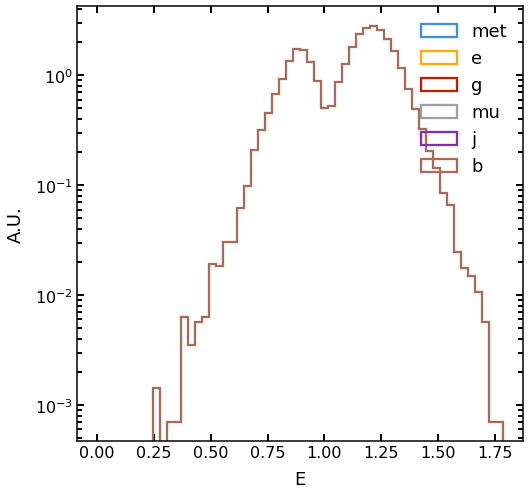

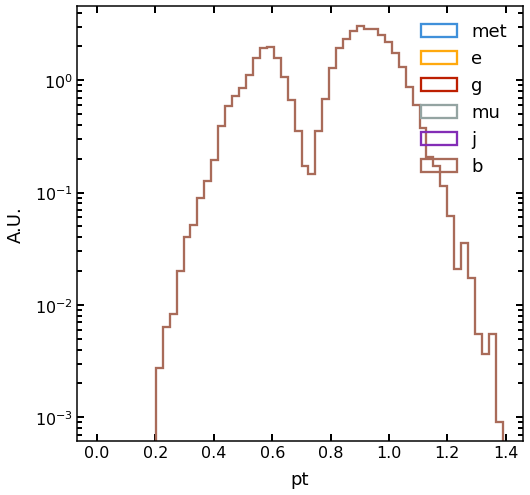

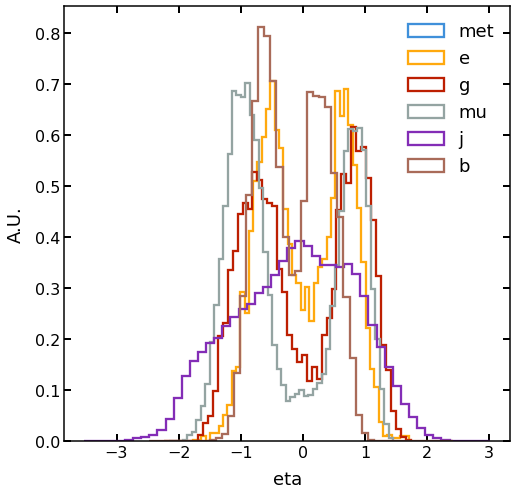

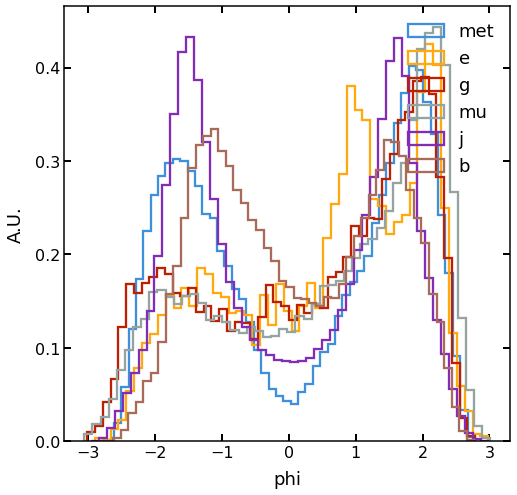

In [15]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_feat,feat in enumerate(feats):
    plt.figure(figsize=(8,8))
    for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
        data = pred_features[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask = data!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0,3,100)
        if feat=='eta':
            bins = np.linspace(-4,4,100)
       # elif i_obj==0:
       #     bins = np.linspace(0.9*np.min(data[mask]),1.1*np.max(data[mask]),100)
        _ = plt.hist(data[mask],bins=50,label=obj,**kwargs)
    plt.xlabel(feat)
    plt.ylabel('A.U.')
    plt.legend(loc='upper right')
    if feat=='E' or feat=='pt' : 
        plt.semilogy()
    #plt.semilogy()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/nump

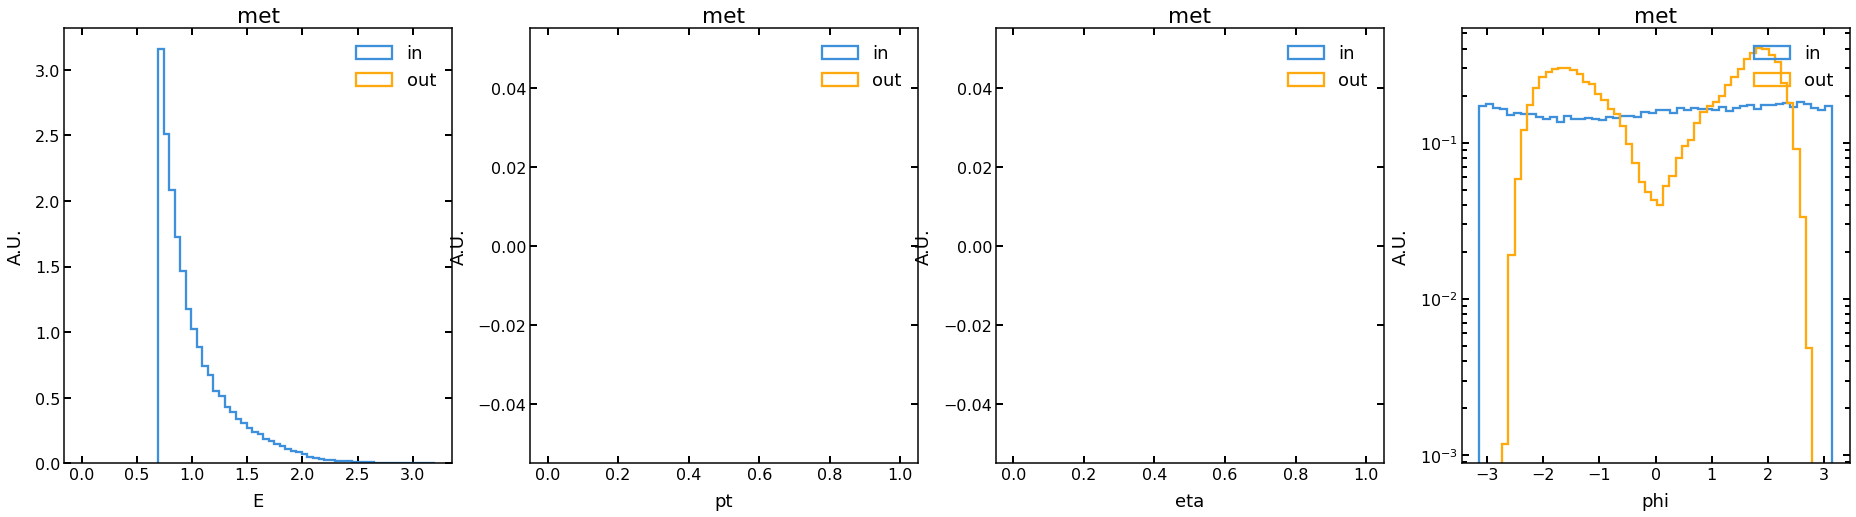

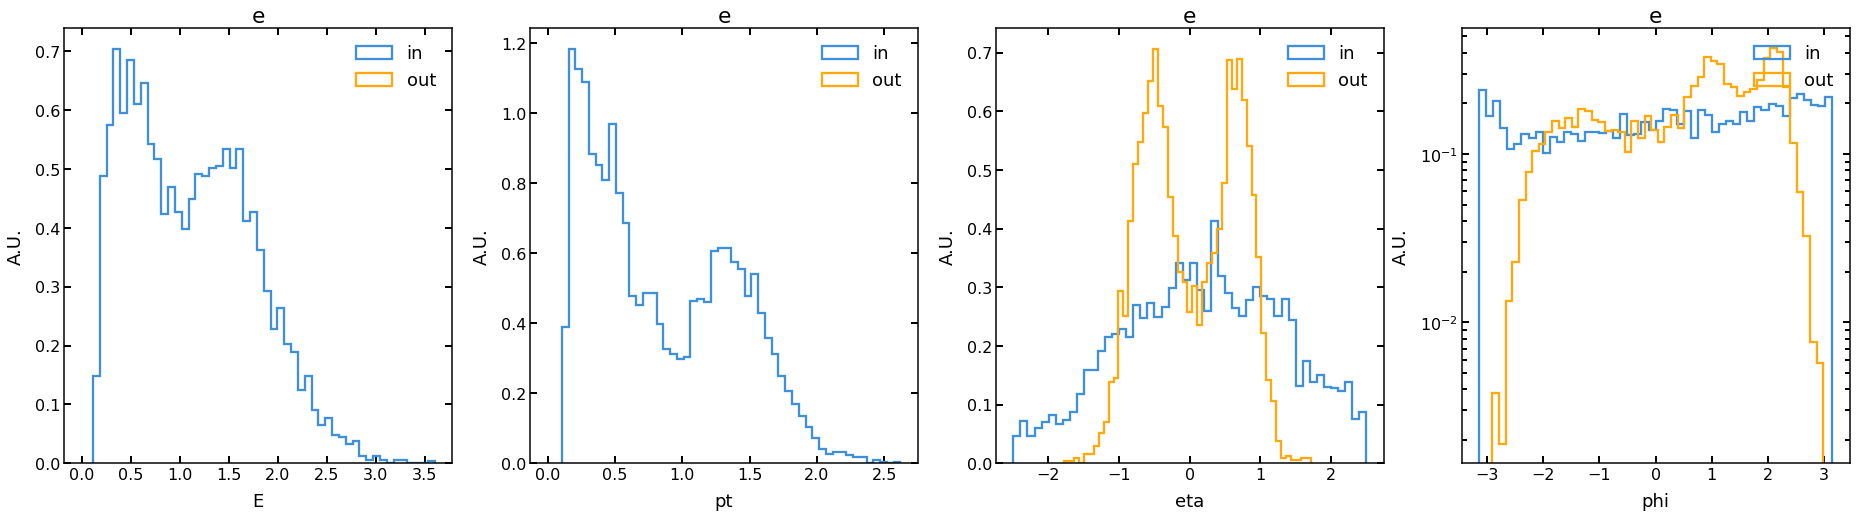

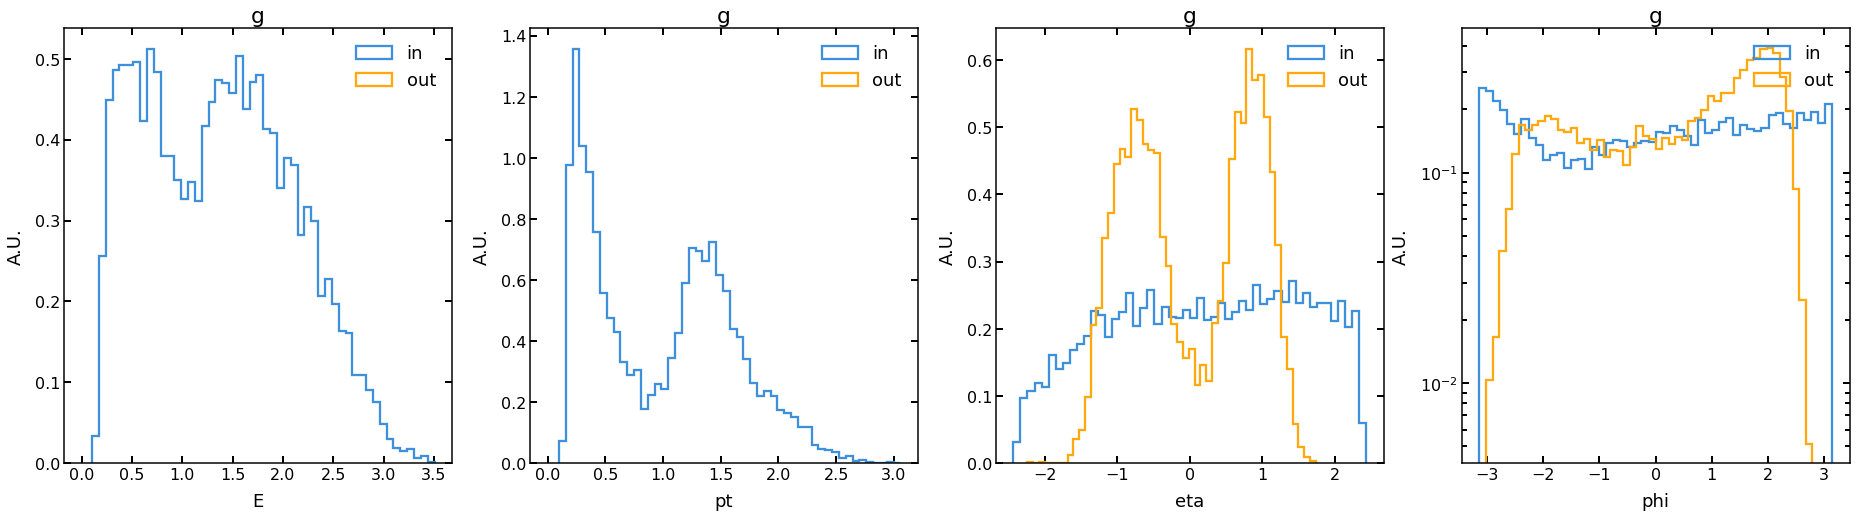

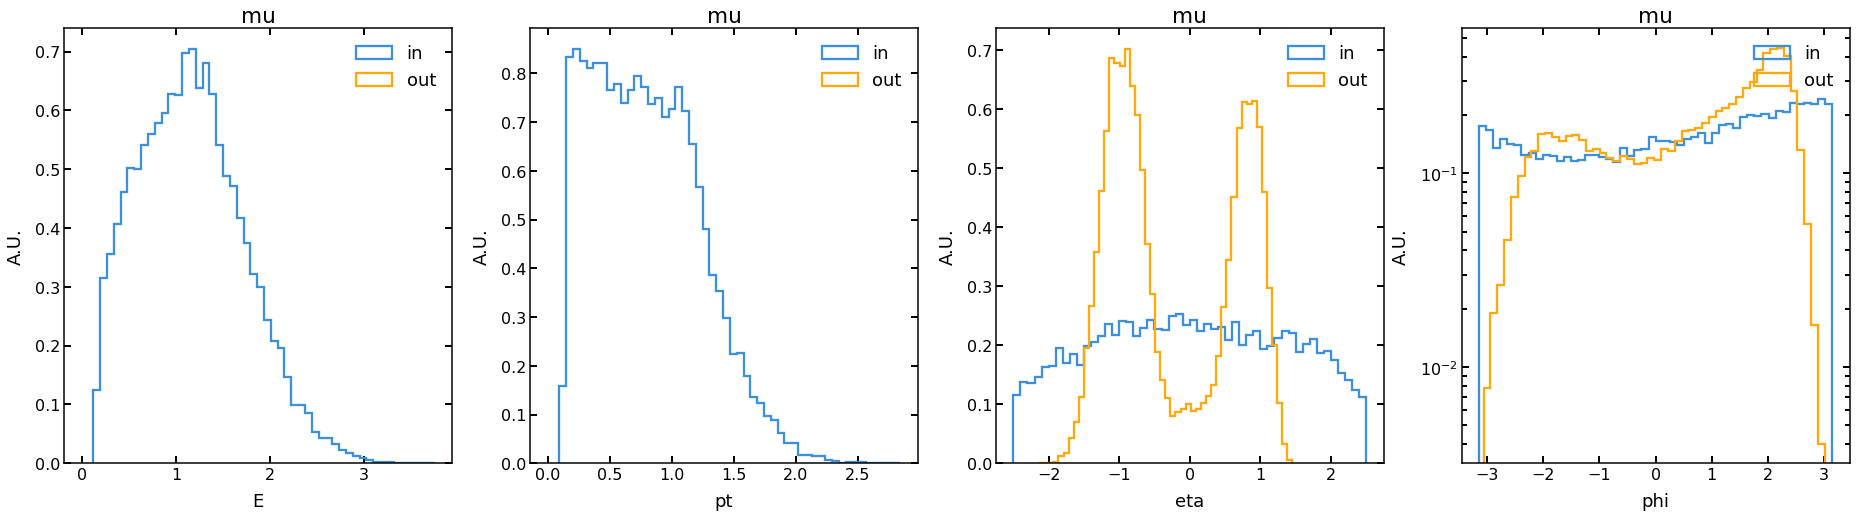

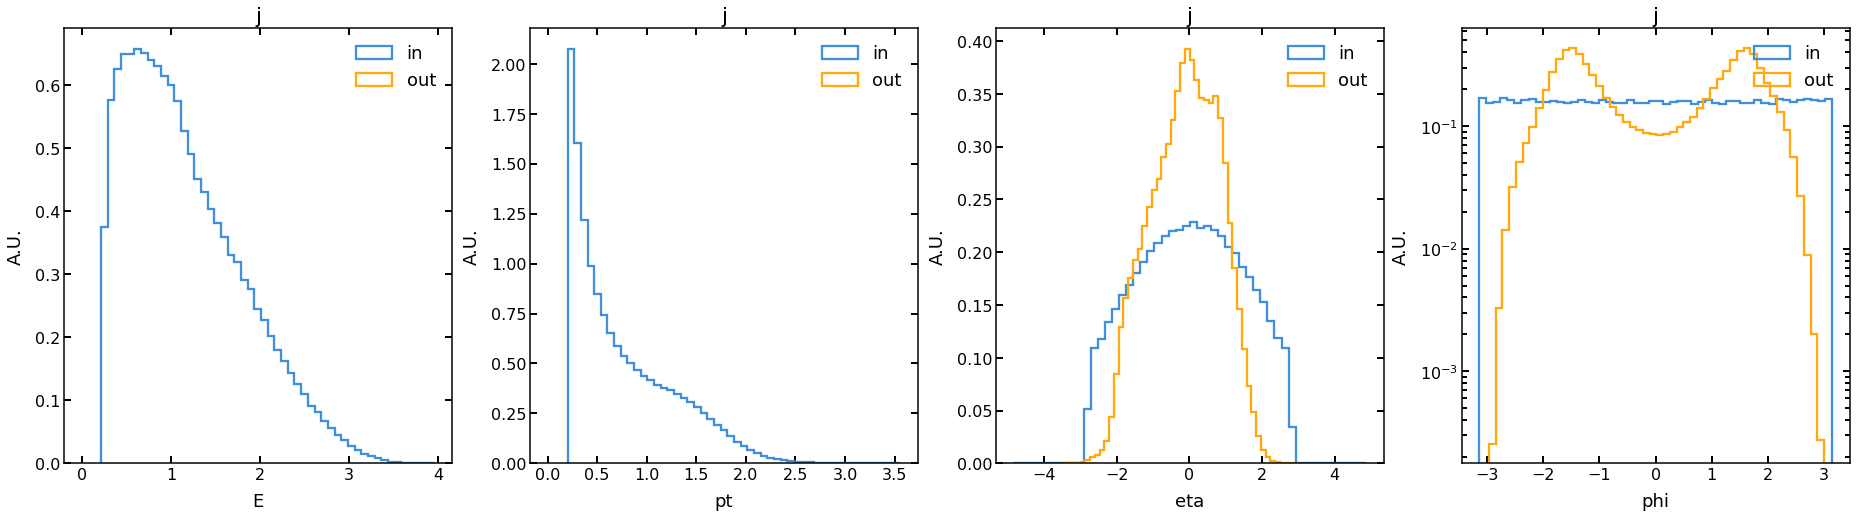

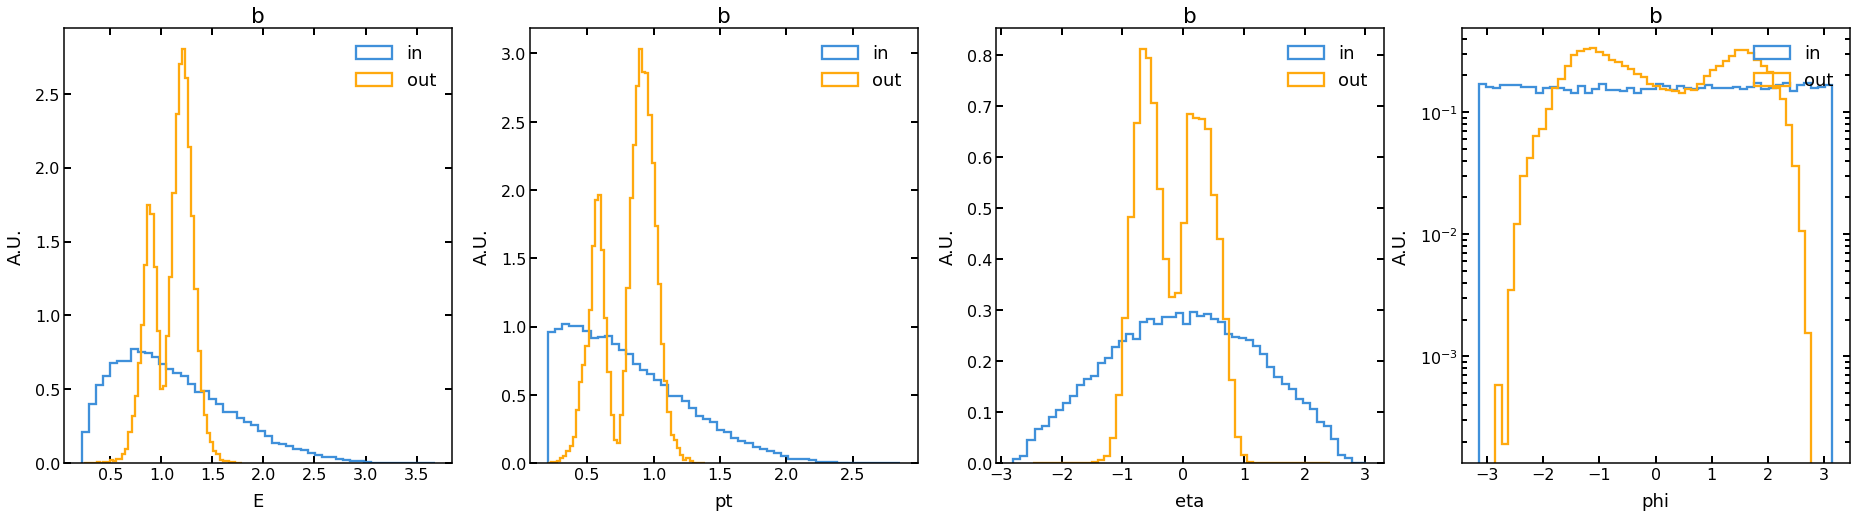

In [95]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
    fig,axs = plt.subplots(1,4,figsize=(32,8))
    axs=axs.reshape(-1)
    for i_feat,feat in enumerate(feats):
        data_true = file_dataset_1d[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask_true = data_true!=0
        data_pred = pred_features[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask_pred = data_pred!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0,3,100)
        if feat=='eta':
            bins = np.linspace(-4,4,30)
        _ = axs[i_feat].hist(data_true[mask_true],bins=50,label='in',**kwargs)
        _ = axs[i_feat].hist(data_pred[mask_pred],bins=50,label='out',**kwargs)
        axs[i_feat].set_title(obj)
        axs[i_feat].set_xlabel(feat)
        axs[i_feat].set_ylabel('A.U.')
        axs[i_feat].legend(loc='upper right')
        if feat=='E' or feat=='pt' : 
            plt.semilogy()
    #plt.semilogy()

In [81]:
d = file_dataset_1d[:,6:16:4]
mask = d!=0
d[mask]

array([ 0.645309 ,  0.876719 ,  0.0926384, ...,  1.83423  , -0.0739344,
       -0.189478 ])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)